#### **Formulating mTSP through MTZ**

MTZ is being selected as the family of Subtour Elimination Constraints (SECs) posed by alternative popular formulations such as DFJ as constraints of DFJ increase exponentially with increasing number of nodes (Bektas, 2006).

**Define a binary variable indicating if an arc is used or unused in a tour:**

$$x_{ij} = 1$$

if arc $(i,j)$ is used on the specific tour, and: 

$$x_{ij} = 0$$

if arc $(i,j)$ is not used on the specific tour.

**Minimize the sum of the cost of the tour:**

$$ minimize \: \Sigma^n_{i=1}\Sigma^n_{j=1} c_{ij}x_{ij}$$

where $C = c_{ij}$ is some distance matrix associated with a set of arcs between the potential "cities" of the mTSP problem

$$s.t. \\ \Sigma^n_{j=1}x_{1j}=m$$

where $m$ is the number of salesmen in the problem. We want $m$ salesmen to leave the initial depot. Essentially we are guaranteeing that this is the single depot version of the problem; maybe this is worth revisiting later on.

**Ensure that m salesmen come back:**

$$\Sigma^n_{j=1}x_{j1}=m$$

**Only one connection is allowed from some city i to some other (non-starting) city j:**

$$\Sigma^n_{i=1}x_{ij}=1, \: j=2,...,n$$

If we don't do this we would allow stuff like multiple routes going from one city to another. This is not good.

**Only one connection is allowed from some city j to some other (non-starting) city i:**

$$\Sigma^n_{j=1}x_{ij}=1, \: i=2,...,n$$

If we don't do this we would allow stuff like multiple routes going from one city to another. This is not good. Combination of last two also prevents things like creating cyclical routes where we go around different cities repeatedly in a circle.

**Make sure everything belongs to the proper set of arcs, make sure no unexpected variable assignments occur:**

$$x_{ij} \in \{0,1\}, \: \forall(i,j) \in A$$

**Subtour elimination constraints:**

We're gonna use MTZ here because it makes for a less complex encoding, though do note that DFJ is a "stronger" formulation, boiling down to having a smaller solution space. Why? I don't really know. Don't ask my why I could not tell you. Anyways:

**SEC FOR mTSP:**

$$u_i - u_j + px_{ij} \leq p - 1$$

p denotes maximum number of nodes which can be visited by a salesman. Node potentials (u's) denote the particular order of visitation. Think of $u_i$ as the node we're on, and $u_j$ as the node we are going to next. Obviously, $u_j$ must be above $u_i$, otherwise the path would "connect in on itself", creating a subtour/cycle. Note that the depot does not have an assigned $u_i$ at the beginning, as that would result in it being impossible for the salesman to return back to the depot.

The above can also be denoted as:

$$u_1 = 1$$
$$\forall i \neq 1: \: 2 \leq u_i \leq n$$
$$\forall \neq 1, \forall j \neq 1 : \: u_i - u_j + 1 \leq (n-1)(1-x_{ij})$$

if $x_{ij} = 1$, i.e. the tour does actually get used, then:

$$u_j \geq u_i + 1$$

This is pretty much exactly what we want. Consider the other case, where $x_{ij} = 0$

$$u_i - u_j + 1 \leq n - 1$$

This is also correct, since we know that the largest difference between two indexes of any (non-depot) nodes does equal to $n - 1$

i.e. if there are ten nodes, the maximum difference between the nodes is 9.

In [508]:
# imports
import random

random.seed(60)

import gurobipy as grb
import numpy as np
import math
import re
from numpy.random import choice, seed
import sys

#important global params.
n_cities = 8
n_salesmen = 5

In [509]:
# Generate set of random points deterministically => straightforward.
def generate_random_coordinates(num_points):
    coordinates = np.asarray([(random.uniform(-1, 1), random.uniform(-1, 1)) for _ in range(num_points)])
    return coordinates

In [510]:
# Generate distance matrix
points = generate_random_coordinates(num_points=n_cities)

# N rows of 2 columns for a 2D space
C = np.zeros((n_cities,n_cities))

for i in range(0, n_cities):
    for j in range(0, len(points)):
        C[i,j] = math.dist(points[i], points[j])

In [511]:
# Set the relevant ranges
set_I = range(0, n_cities)
set_J = range(0, n_cities)

# Transform the problem into a tuplelist -> basically creates a graph of all possible connections
#tuple_list_graph = grb.tuplelist([(i, j) for i in set_I for j in set_I if i != j])

# Set up a Gurobi optimizer, name it accordingly.
opt_model = grb.Model(name="mTSP Optimizer")

# X, denoting if a route is used or not, is a binary variable. Sets up our connection of matrices.
x_vars  ={(i,j):opt_model.addVar(vtype=grb.GRB.BINARY,
                        lb=0, 
                        ub= n_cities,
                        name="x_{0}_{1}".format(i,j))
                        for i in set_I for j in set_J} 

# u variables, tracking order of different visited nodes.
u_vars  = opt_model.addVars(set_I, vtype=grb.GRB.INTEGER, lb=0)

# The constraints - conventions follow Bektas, 2006 - Problem code:
opt_model.addConstr(grb.quicksum([x_vars[0, i] for i in range(1, n_cities)]) == n_salesmen)

opt_model.addConstr(grb.quicksum([x_vars[i, 0] for i in range(1, n_cities)]) == n_salesmen)

for j in range(1, n_cities):
    opt_model.addConstr(grb.quicksum(x_vars[i, j] for i in range(n_cities) if i != j) == 1)

for i in range(1, n_cities):
    opt_model.addConstr(grb.quicksum(x_vars[i, j] for j in range(n_cities) if i != j) == 1)

# The main SEC constraint:
for i, j in x_vars:
    if (i != 0 and j != 0):
        opt_model.addConstr(u_vars[i] - u_vars[j] + n_cities * x_vars[i, j] <= n_cities - 1)

#opt_model.addConstr(u_vars[0] == 1)

# Set the objective.
opt_model.setObjective(grb.quicksum([C[i][j] * x_vars[i, j] for i, j in x_vars]), grb.GRB.MINIMIZE)

# Now optimize the model
opt_model.optimize()


print('The optimal objective is %g' % opt_model.objVal)
result = {e: x_vars[e].X for e in x_vars}
print(result)


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-12700K, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 401 rows, 420 columns and 1805 nonzeros
Model fingerprint: 0x57eeaa04
Variable types: 0 continuous, 420 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [6e-02, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 19 rows and 21 columns
Presolve time: 0.00s
Presolved: 382 rows, 399 columns, 1786 nonzeros
Variable types: 0 continuous, 399 integer (380 binary)
Found heuristic solution: objective 17.3712465

Root relaxation: objective 6.393760e+00, 78 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


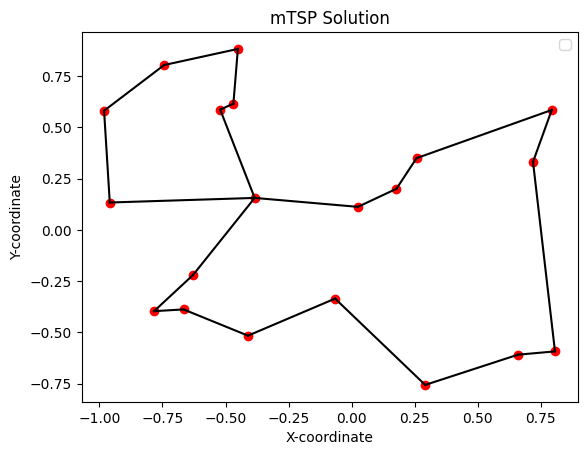

In [512]:
# Now, the fun part, let's visualize:
import matplotlib.pyplot as plt

# Extract solution values
solution = opt_model.getAttr('X', x_vars)
routes = [(i, j) for i, j in solution if solution[i, j] > 0.5]

# Extract u_vars values
node_order = [int(re.search(r'\d+', var.VarName).group()) for var in u_vars.values()]
order_dict = dict(zip(range(n_cities), node_order))

# Sort routes by order
sorted_routes = sorted(routes, key=lambda x: order_dict[x[0]])

# Plot the cities
for i, (x, y) in enumerate(points):
    plt.plot(x, y, 'o', color='red')

# Plot the routes
for i, j in sorted_routes:
    plt.plot([points[i][0], points[j][0]],
             [points[i][1], points[j][1]], 'k-')

plt.title('mTSP Solution')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.show()

#### **Ant Colony Optimization**

**The algorithms:**

Below are the most relevant ACO algorithms developed according to Handbook of Metaheuristics - 3rd ed. (as of 2019, I think that's recent enough)

| ACO algorithm        | Year |
|----------------------|------|
| Ant System           | 1991 |
| Elitist AS           | 1992 |
| Ant-Q                | 1995 |
| Ant Colony System    | 1996 |
| MMAS                 | 1996 |
| Rank-based AS        | 1997 |
| Best-Worst AS        | 2000 |
| Population-based ACO | 2002 |

Below will be a general summary of ACO (Ant System in particular), mostly according to The Handbook.

**The basics:**

ACO is a metaheuristic for solving hard combinatorial optimization problems. The inspiration is the phermone trails laid by ants as a communication medium. ACO is based on communication between simple ant-like agents. Phermone trails serve as distributed, numerical information used by ants for constructing solutions to problems being solved, adapted during algorithm execution to reflect search experience. First is Ant System.

Ants in ACO implement a randomized construction heuristic, which makes probabilistic decisions as a function of pheromone trails. ACO is an extension of construction heuristics.

**Approximate Algorithms:**

There exist two types of approximation methods *construction algorithms* and *local search algorithms*.

Construction algorithms build solutions incrementally, starting with an empty initial solution and iteratively adding solution components. In it's simplest form, the construction is done randomly - otherwise, heuristics can be added to achieve maximal benefit.

Alternatively, there exist local search algorithms. They start from some complete initial solution and try to find a better solution in some defined neighborhood of a current working solution. Current solutions are replaced by improving neighboring solutions. These swaps are then made until no improvements are found, resulting in a local optima.

**ACO metaheuristic:**

Ants in ACO are stochasitc construction procedures, probabilisticaly building a solution iteratively through adding solution components to partial solutions through:
1. Heuristics
2. Pheromone trails
Experience, I assume though pheromone trails, influences future interactions of ACO at work. 

**Generic Problem Representation:**

A model $P = (S, \Omega, f)$ of combinatorial optimization consists of some:

1. $S$ search space, finite set of decision variables or a finite domain
2. $\Omega$ set of constraints
3. Objective function $f: S\rightarrow \mathbb{R}_0^+$ to be minimized

The search space is some variables $X_i, i = 1,...,n$ each having a domain $D_i$ x's have some assignment v's. A feasible solution *s* is an assignment where the constraints are all satisfied.

We can use this understanding of the model to apply it to ACO. $X_i$ can be instantiated with a particular value $v^j_i$ of its domain to create a solution component. This solution component can be denoted by $c^j_i$. Ants need to then also combine appropriate solution components to create high-quality solutions. Each solution component needs to have an associated pheromone variable $T_{ij}$. Set of all solutions is *C* and set of all pheromone variables is *T*. Each member of *T* has some $t_{ij}$

**Algorithm Overview:**

def ACO():
    Initialize variables();
    while (termination condition != True){
        ConstructAntSolutions(m); <- This is done by some m ants
        ApplyLocalSearch(); <- Optional step
        GlobalUpdatePheromones(t); <- Pheromones are time varying so as a result they depend on termination
    }

**ConstructAntSolutions(m):**
A set of *m* ants constructs some solutions. Each ant starts empty and extends its solution by choosing another feasible component, adding it to the solution. This is done in accordance to the earlier-defined constraints.

The choice of solution is done probabilistically at each construction step through some formula as defined in Ant System (AS)

$$p(c^j_i|s_p) = \frac{t^{a}_{ij}\cdot[\eta(c^j_i)^\beta]}{\Sigma_{c^l_i}t^a_{il}\cdot[\eta(c^l_i)^\beta]}$$

Note that all c's here are a part of the set of all feasible solution components. Here, $\eta$ assigns some heuristic value to a solution component, usually called heuristic information. Alpha and beta determine the relative influence of pheromone trails and heuristic info.

**ApplyLocalSearch()**

Once there is a complete candidate solution, they can be further improved by some local search algorithm. This works best apparently.

**GlobalUpdatePhermones():**

Solution components belonging to good solutions are more desirable. Pheromone deposit increases level of good solution components, the next is trail evaporation, which decreases the pheromone deposited by ants. Pheromone evaporation is needed from too rapid convergenece.

$$t_{ij} = (1-\rho)t_{ij}+\Sigma_{s\in S_{upd} | c^j_i \in s} g(s)$$

S_upd is the set of solutions used to determine pheromone deposit, rho is the ebaporation rate, and g is a function which determines the quality of a solution (i.e. an evaluation function).

Usually, $S_{upd}$ is a subset of $S_{iter} \cup \{s_{gb}\}$

S_iter is solutions found on the current iteration, and sgb is the best solution across all iterations.

#### **Ant System time**

In ant system each ant is put on a rando city and has a memory which stores partial solutions constructed so far. Initially, the memory contains only one city. The ant interatively moves from city to city, corresponding to iteratievily adding solution components. Then, the next city is probabilistically chosen as explained by earlier equation.

In ant systems, updates are done via:

$$S_{upd} = S_{iter}$$

and

$$g(s)=1/f(s)$$

Where, f is the length of tour s. The shorter the ant's tour, the more pheromone is deposited. Okay, let's try implementing it.

The heuristic, $\eta$, is given by $\eta_{ij} = 1/d_{ij}$

In [513]:
class AntSystem:
    def __init__(self, points, n_ants, init_pheromones, n_salesmen, alpha, beta):
        self.n_salesmen = n_salesmen
        self.n_cities = len(points)

        self.alpha = alpha
        self.beta = beta

        # MTZ
        self.u = [[] for _ in range(n_ants)]

        # Our data points
        self.points = points

        # Create our list of ants which take certain paths -> instantiates a 3D array with ant paths   
        self.ants = [np.zeros((len(self.points), len(self.points))) for _ in range(n_ants)]

        # Pheromones between different points
        self.pheromones = np.full((len(points), len(points)), init_pheromones)

    def random_choice_2d(self, matrix, probabilities, random_seed=60):
        flat_probabilities = probabilities.flatten()

        # Pick random indices from matrix of probabilities
        if random_seed is not None:
            np.random.seed(random_seed)

        _, cols = matrix.shape
        flat_matrix = matrix.flatten()
        
        flat_indices = np.random.choice(range(len(flat_matrix)), size=1, p=flat_probabilities)
        selected_row, selected_col = divmod(flat_indices[0], cols)

        return selected_row, selected_col
    
    def calculate_probabilities(self, possibility_matrix, alpha, beta):
        
        movement_probabilities = np.ones(np.shape(possibility_matrix))
        
        # Ant System function denominator
        denominator_sum = 0
        for i in range(len(possibility_matrix)):
            for j in range(len(possibility_matrix[i])):
                if possibility_matrix[i][j] != 0:
                    denominator_sum += (self.pheromones[i][j]**alpha)*((1/C[i][j])**beta)

        # Ant System function to assign travel probabilities
        for i in range(len(movement_probabilities)):
            for j in range(len(movement_probabilities[i])):
                if possibility_matrix[i][j] == 0:
                    movement_probabilities[i][j] = 0
                else:
                    movement_probabilities[i][j] = (self.pheromones[i][j]**alpha * (1/C[i][j])**beta)/denominator_sum

        return movement_probabilities

    
    def move_ant(self, salesmen_matrix, possibility_matrix, u_matrix, alpha, beta):

        movement_probabilities = self.calculate_probabilities(possibility_matrix=possibility_matrix, alpha=alpha, beta=beta)

        # If there are no more moves, just return the original matrix.
        if(np.sum(movement_probabilities) == 0.0):
            return movement_probabilities

        while True:
            x_index, y_index = self.random_choice_2d(salesmen_matrix, movement_probabilities)

            # Check if MTZ constraint is violated
            u_i = next((u for u, city_id in u_matrix if city_id == x_index), None)
            u_j = next((u for u, city_id in u_matrix if city_id == y_index), None)

            if u_i is not None and u_j is not None and u_i != u_j and (u_i - u_j + len(self.points) > len(self.points) - 1):
                possibility_matrix[x_index][y_index] = 0

                # Recalculate movement probabilities
                movement_probabilities = self.calculate_probabilities(possibility_matrix=possibility_matrix, alpha=alpha, beta=beta)

                # Choose new indices based on updated probabilities
                continue
            else:
                # MTZ constraint is satisfied
                break

        # Update u_matrix based on the chosen indices
        if any(city_id == x_index for _, city_id in u_matrix):
            u_matrix.append((len(u_matrix), y_index))
        else:
            u_matrix.append((len(u_matrix), x_index))
            u_matrix.append((len(u_matrix) + 1, y_index))

        print(u_matrix)

        # Set salesmen_matrix[city_id][j] to 1
        salesmen_matrix[x_index][y_index] = 1

        return movement_probabilities

    def prune_impossible_indices(self, salesmen_matrix, u_matrix):
        # Instantiate a matrix which checks which movements are even possible
        possible_check = np.ones(np.shape(salesmen_matrix))
        
        # Fill diagonals with 0
        np.fill_diagonal(possible_check, 0)
    
        # First, send out m salesmen
        if np.sum(salesmen_matrix[0, :]) != self.n_salesmen:
            
            movement_probabilities = possible_check[0]
            denominator_sum = 0

            for i in range(self.n_cities):
                if(C[0][i] != 0):
                    denominator_sum += (self.pheromones[0][i]**self.alpha)*((1/C[0][i])**self.beta)

            for i in range(self.n_cities):
                if(C[0][i] != 0):
                    movement_probabilities[i] = (self.pheromones[0][i]**self.alpha * (1/C[0][i])**self.beta)/denominator_sum
            
            indices = np.random.choice(np.arange(len(movement_probabilities)), size=self.n_salesmen, replace=False, p=movement_probabilities)

            for i in range(len(indices)):
                u_matrix.append((i, indices[i]))
                salesmen_matrix[0][indices[i]] = 1

            # Now that m salesmen have been sent out, make sure that no more can be sent out.
            possible_check[:, 0] = 0
        
        # Do not come back until all cities visited
        if np.sum(salesmen_matrix[:, 1:]) != len(self.points) - 1:
            possible_check[:, 0] = 0
            
        # Check that m salesman are departing
        if np.sum(salesmen_matrix[0, :]) >= self.n_salesmen:
            possible_check[0, :] = 0

        # If there is a row > 0 where one of the cities has been visited, the possibilities for that row are now 0
        for i in range(1, len(salesmen_matrix)):
            if np.sum(salesmen_matrix[i]) == 1:
                    possible_check[i, :] = 0

        # If there is a column > 0 where one of the cities has been visited, the possibilities for that column are now 0
        column_iter = salesmen_matrix.T
        possible_check = possible_check.T

        for i in range(1, len(column_iter)):
            if np.sum(column_iter[i]) == 1:
                possible_check[i, :] = 0
        
        possible_check = possible_check.T

        '''for (u_i, city_id) in u_matrix:
            for j in range(len(salesmen_matrix[city_id])):
                if salesmen_matrix[city_id][j] == 1 and city_id != j:

                    matching_u = next((u for u, cid in u_matrix if cid == j), None)

                    if matching_u is not None:
                        u_j = matching_u
                    else:
                        u_j = len(u_matrix)
                    
                    # Broken, we shouldn't just be marking the city we are going to, we should also be marking the cities we are coming from as well.
                    if u_i != u_j and (u_i - u_j + (len(self.points)) > len(self.points) - 1):
                        print("Found a subtour! Condition 1. The value of u_i is " + str(u_i) + " The value of u_j is " + str(u_j)+ " where we are going from city " + str(city_id) + " to " + str(j))
                        possible_check[city_id][j] = 0'''

        print("\nThe current salesman matrix is:\n")
        print(salesmen_matrix)

        print("\nThe current possibility matrix is:\n")
        print(possible_check)

        return possible_check

    def construct_ant_solutions(self):
        # Old seed is 60, for consistency
        random.seed(59)

        movement_probabilities = [1]

        # Build a complete solution for the ant
        while(np.sum(movement_probabilities) != 0):
            probability_matrix = self.prune_impossible_indices(self.ants[0], self.u[0])
            movement_probabilities = self.move_ant(self.ants[0], probability_matrix, self.u[0], self.alpha, self.beta)      

        print(self.ants[0])
        return self.ants[0]

    def display_solution(self, points, solution):
        routes = [(i, j) for i in range(solution.shape[0]) for j in range(solution.shape[1]) if solution[i, j] > 0.5]

        # Plot the cities
        for i, (x, y) in enumerate(points):
            if i == 0:  # Highlight the first "depot" coordinate
                plt.plot(x, y, 'o', color='green', label='Depot')
            else:
                plt.plot(x, y, 'o', color='red')

        # Plot the routes with arrows
        for i, j in routes:
            plt.arrow(points[i][0], points[i][1], points[j][0] - points[i][0], points[j][1] - points[i][1],
                    shape='full', lw=0.1, length_includes_head=True, head_width=0.02, color='blue')

        plt.title('mTSP Solution with Arrows')
        plt.xlabel('X-coordinate')
        plt.ylabel('Y-coordinate')
        plt.legend()
        plt.show()


The current salesman matrix is:

[[0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0

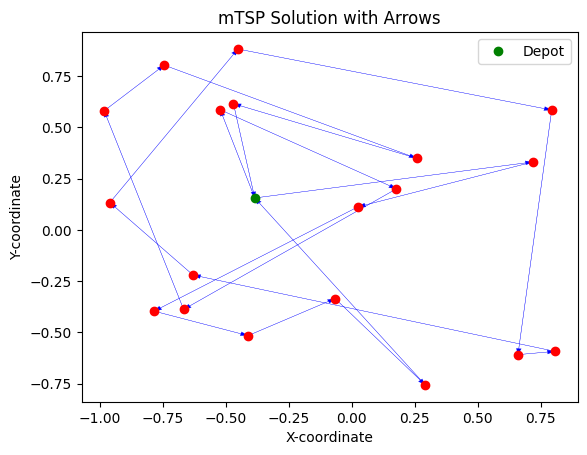

In [514]:
AS_test = AntSystem(points=points, n_ants=1, init_pheromones=1, n_salesmen=n_salesmen, alpha=1, beta=1)
solution = AS_test.construct_ant_solutions()
AS_test.display_solution(points, solution)